In [50]:
'''
READ IN CLEANED FILE FROM S3
'''

import boto3
import pandas as pd
from io import StringIO

# Initialize S3 client
s3 = boto3.client('s3')

# Define S3 bucket and file key
bucket_name = 'abbynlpproject'
file_key = 'cleaned_goodreads_reviews.csv'

# Download the file
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
df = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8')))

# Check the first few rows
print(df.head())

                                               title   book_id  \
0  The Three-Body Problem (Remembrance of Earth’s...  18245960   
1                                           Stardust   5577844   
2                                        The Martian  17315048   
3                            Wool Omnibus (Silo, #1)  13453029   
4                                    Alif the Unseen  13239822   

                                 cleaned_review_text  rating  
0  special book started slow first third middle t...       5  
1  beautiful story neil gaiman truly unique story...       5  
2  mark watney steelyeyed missile man man man bad...       5  
3  fun fast paced book suck right away doesnt let...       4  
4  book great premise full beautifully written pr...       3  


In [48]:
from langdetect import detect
import langdetect.lang_detect_exception

# Function to detect language safely
def detect_language(text):
    try:
        return detect(text)
    except langdetect.lang_detect_exception.LangDetectException:
        return "unknown"

# Get the top 10 books with the most reviews
top_books = df['title'].value_counts().head(50).index.tolist()

# Filter the dataset for the top 10 books with the most reviews
top_books_reviews = df[df['title'].isin(top_books)].copy()

# Apply language detection to the top books' reviews
top_books_reviews["language"] = top_books_reviews["cleaned_review_text"].astype(str).apply(detect_language)

# Keep only English reviews
df_english_top_books = top_books_reviews[top_books_reviews["language"] == "en"].copy()

# Drop the 'language' column as it's no longer needed
df_english_top_books.drop(columns=["language"], inplace=True)

# Check how many English reviews we have in the dataset for the top books
print(f"Total English reviews from top books: {len(df_english_top_books)}")


Total English reviews from top books: 286694


In [52]:
import re
def clean_text_numbers(text):
    return re.sub(r'\b\d+\b', '', text)  # removes standalone numbers

df['cleaned_review_text'] = df['cleaned_review_text'].apply(clean_text_numbers)

In [24]:
from collections import Counter
from math import log
import pandas as pd

# Function to compute log odds ratios for a book's reviews
def compute_log_odds_ratios(book_title, df):
    # Filter the dataset for the selected book
    book_reviews = df[df['title'] == book_title]
    
    # Drop any rows with missing or invalid review text
    book_reviews = book_reviews.dropna(subset=['cleaned_review_text'])
    
    # Separate positive and negative reviews based on rating (threshold of 3.5)
    negative_reviews = book_reviews[book_reviews['rating'] <= 3.5]
    positive_reviews = book_reviews[book_reviews['rating'] > 3.5]

    # Count the word frequencies in both groups
    def count_words(reviews):
        all_words = [word for text in reviews if isinstance(text, str) for word in text.split()]
        return Counter(all_words)

    # Count word frequencies for both positive and negative reviews
    negative_word_counts = count_words(negative_reviews['cleaned_review_text'])
    positive_word_counts = count_words(positive_reviews['cleaned_review_text'])

    # Get the total number of words in each group
    total_negative_words = sum(negative_word_counts.values())
    total_positive_words = sum(positive_word_counts.values())

    # Get the number of unique words in each group
    num_unique_neg_words = len(negative_word_counts)
    num_unique_pos_words = len(positive_word_counts)

    # Dirichlet prior smoothing parameter (could be adjusted)
    alpha = 1  # This is the hyperparameter (similar to Laplace's smoothing)

    # Compute the log odds ratio for each word using Dirichlet prior
    log_odds_ratios = {}

    # Iterate through all words in the negative review word count
    for word in negative_word_counts:
        # Word count in negative and positive reviews
        negative_count = negative_word_counts.get(word, 0)
        positive_count = positive_word_counts.get(word, 0)

        # Total number of words in each group
        neg_total = total_negative_words
        pos_total = total_positive_words

        # Apply Dirichlet prior smoothing
        p_neg = (negative_count + alpha) / (neg_total + alpha * num_unique_neg_words)
        p_pos = (positive_count + alpha) / (pos_total + alpha * num_unique_pos_words)

        # Log odds ratio formula: log(p_neg / p_pos)
        if p_pos > 0:  # Avoid division by zero
            log_odds = log(p_neg / p_pos)
        else:
            log_odds = float('inf')  # If no word in positive reviews, set a large value

        # Store the log odds ratio for each word
        log_odds_ratios[word] = log_odds

    # Sort by log odds ratio (positive log odds mean more common in negative reviews, negative in positive reviews)
    sorted_log_odds = sorted(log_odds_ratios.items(), key=lambda x: x[1], reverse=True)

    # Display top 10 words with the highest log odds ratio (positive words are more common in negative reviews)
    print(f"Top 10 words most associated with negative reviews for '{book_title}':")
    for word, ratio in sorted_log_odds[:10]:
        print(f"{word}: {ratio}")

    # Display top 10 words with the lowest log odds ratio (negative words are more common in positive reviews)
    print(f"\nTop 10 words most associated with positive reviews for '{book_title}':")
    for word, ratio in sorted_log_odds[-10:]:
        print(f"{word}: {ratio}")

In [29]:
print(df_english_top_books['title'].unique())  # Display all unique book titles

['The Martian' 'Twilight (Twilight, #1)' 'The Night Circus'
 'Harry Potter and the Cursed Child - Parts One and Two (Harry Potter, #8)'
 'A Game of Thrones (A Song of Ice and Fire, #1)'
 'City of Bones (The Mortal Instruments, #1)'
 "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)"
 'Miss Peregrine’s Home for Peculiar Children (Miss Peregrine’s Peculiar Children, #1)'
 'Throne of Glass (Throne of Glass, #1)'
 'Cinder (The Lunar Chronicles, #1)']


In [46]:
# Example usage:
book_title = 'The Martian'  # Change this to any other book title
compute_log_odds_ratios(book_title, df_english_top_books)

Top 10 words most associated with negative reviews for 'The Martian':
natalie: 5.04413878419211
unpopular: 3.778472410860834
cringeworthy: 3.6831622310565093
sexism: 3.4600186797422996
douche: 3.326487287117777
rly: 3.326487287117777
torture: 3.1723366072905184
quitting: 3.1723366072905184
voltage: 3.1723366072905184
dnf: 3.054553571634135

Top 10 words most associated with positive reviews for 'The Martian':
asimov: -1.5097946198337011
mustread: -1.5097946198337011
riveting: -1.520844456020286
sucked: -1.5371935940218155
bed: -1.5638618411039769
king: -1.5898373275072375
bray: -1.6095840904420717
laughing: -1.6565923253557004
recommending: -1.8180959794882177
thousand: -1.9152597279418655


In [47]:
# Example usage:
book_title = 'Harry Potter and the Cursed Child - Parts One and Two (Harry Potter, #8)'  # Change this to any other book title
compute_log_odds_ratios(book_title, df_english_top_books)

Top 10 words most associated with negative reviews for 'Harry Potter and the Cursed Child - Parts One and Two (Harry Potter, #8)':
notion: 2.5953957527917617
lackluster: 2.5953957527917617
poorly: 2.5537230563911937
severely: 2.441245072964503
retired: 2.3542336959748735
mary: 2.3077136803399805
clumsy: 2.2589235161705488
obliviate: 2.2589235161705488
garbage: 2.2589235161705488
onedimensional: 2.2589235161705488

Top 10 words most associated with positive reviews for 'Harry Potter and the Cursed Child - Parts One and Two (Harry Potter, #8)':
designer: -1.7484096690619222
wink: -1.7484096690619222
answered: -1.7664281745646004
exceeded: -1.8354210460515519
disagree: -1.8682108688745427
engrossed: -1.9154637537250885
bittersweet: -1.9154637537250885
worldwide: -1.9154637537250885
catching: -1.9532040817079355
cynical: -2.2408861541597163


In [31]:
# Example usage:
book_title = 'City of Bones (The Mortal Instruments, #1)'  # Change this to any other book title
compute_log_odds_ratios(book_title, df_english_top_books)

Top 10 words most associated with negative reviews for 'City of Bones (The Mortal Instruments, #1)':
plagiarized: 3.371864247665756
shrug: 2.8013193891981425
overwrought: 2.7212766815246066
jackass: 2.7212766815246066
underwhelmed: 2.7212766815246066
abandon: 2.5389551247306517
lift: 2.5389551247306517
ol: 2.5389551247306517
mediocre: 2.487661830343101
allegation: 2.4335946090728253

Top 10 words most associated with positive reviews for 'City of Bones (The Mortal Instruments, #1)':
tomorrow: -1.800511895524434
thrill: -1.8430715099432298
clace: -1.8738431686099835
pettyfer: -1.883893504463485
enchanting: -1.9608545455996131
fierce: -2.014921766869889
heavenly: -2.0662150612574397
merged: -2.183998096913823
phenomenal: -2.471680169365604
wonderfully: -2.471680169365604


In [ ]:
'''
Make the table for the database that the user will query
'''

In [53]:
from collections import Counter
from math import log
import pandas as pd

# Step 1: Your original log odds function (unchanged)
def compute_log_odds_ratios(book_title, df):
    book_reviews = df[df['title'] == book_title]
    book_reviews = book_reviews.dropna(subset=['cleaned_review_text'])
    negative_reviews = book_reviews[book_reviews['rating'] <= 3.5]
    positive_reviews = book_reviews[book_reviews['rating'] > 3.5]

    def count_words(reviews):
        all_words = [word for text in reviews if isinstance(text, str) for word in text.split()]
        return Counter(all_words)

    negative_word_counts = count_words(negative_reviews['cleaned_review_text'])
    positive_word_counts = count_words(positive_reviews['cleaned_review_text'])

    total_negative_words = sum(negative_word_counts.values())
    total_positive_words = sum(positive_word_counts.values())

    num_unique_neg_words = len(negative_word_counts)
    num_unique_pos_words = len(positive_word_counts)

    alpha = 1
    log_odds_ratios = {}

    for word in set(list(negative_word_counts.keys()) + list(positive_word_counts.keys())):
        negative_count = negative_word_counts.get(word, 0)
        positive_count = positive_word_counts.get(word, 0)

        p_neg = (negative_count + alpha) / (total_negative_words + alpha * num_unique_neg_words)
        p_pos = (positive_count + alpha) / (total_positive_words + alpha * num_unique_pos_words)

        log_odds = log(p_neg / p_pos) if p_pos > 0 else float('inf')
        log_odds_ratios[word] = log_odds

    sorted_log_odds = sorted(log_odds_ratios.items(), key=lambda x: x[1], reverse=True)
    return sorted_log_odds

In [99]:
book_review_counts = df['title'].value_counts()

books_over_50_reviews = book_review_counts[book_review_counts > 50].index.tolist()

# Step 3: For each book, compute log odds and store results
results = []

for title in books_over_50_reviews:
    try:
        sorted_log_odds = compute_log_odds_ratios(title, df)

        top_positive = [{"word": w, "log_odds": val} for w, val in sorted_log_odds[-10:]]  # most positive-leaning
        top_negative = [{"word": w, "log_odds": val} for w, val in sorted_log_odds[:10]]   # most negative-leaning

        avg_rating = df[df['title'] == title]['rating'].mean()

        results.append({
            "title": title,
            "average_rating": avg_rating,
            "top_positive_words": top_positive,
            "top_negative_words": top_negative
        })
    except Exception as e:
        print(f"Skipping '{title}' due to error: {e}")


Skipping 'Embrace (Gryphon, #2)' due to error: division by zero
Skipping 'Souls (Runes, #5)' due to error: division by zero
Skipping 'Gathering Storm (Knights of Black Swan, #5)' due to error: division by zero


In [106]:
results_df = pd.DataFrame(results)
results_df.sample(5)

,title,average_rating,top_positive_words,top_negative_words
1870,"Silver Silence (Psy-Changeling Trinity, #1; Ps...",4.174672,"[{'word': 'playful', 'log_odds': -1.2151599937...","[{'word': 'silenced', 'log_odds': 3.3387168978..."
3564,"Kushiel's Mercy (Imriel's Trilogy, #3)",4.134454,"[{'word': 'main', 'log_odds': -1.4398313309300...","[{'word': 'ange', 'log_odds': 2.47219167449805..."
1980,"The Sweetest Dark (The Sweetest Dark, #1)",3.671296,"[{'word': 'learned', 'log_odds': -1.6118440533...","[{'word': 'connect', 'log_odds': 2.88796561693..."
2716,The Reflections of Queen Snow White,3.852564,"[{'word': 'facing', 'log_odds': -1.44669290624...","[{'word': 'unfortunately', 'log_odds': 3.15847..."
1985,A Tangle of Knots,3.762791,"[{'word': 'interconnected', 'log_odds': -1.388...","[{'word': 'ended', 'log_odds': 2.6369374199530..."


In [107]:
import json

# Convert list of results to a JSON string
json_data = json.dumps(results, indent=2)

In [108]:
import boto3

# Set up S3 client
s3 = boto3.client('s3')

# Define your bucket and object key (path + filename)
bucket_name = 'abbynlpproject'
object_key = 'log_odds_results.json'  # you can omit the folder part if you want it at the root

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=object_key, Body=json_data)

print("Upload successful!")

Upload successful!


In [110]:
'''
Visualization
'''

# Find the result for "The Martian"
martian_data = next((book for book in results if book['title'] == 'The Martian'), None)

if martian_data is None:
    print("The Martian not found in results.")
else:
    print("Found The Martian!")


Found The Martian!


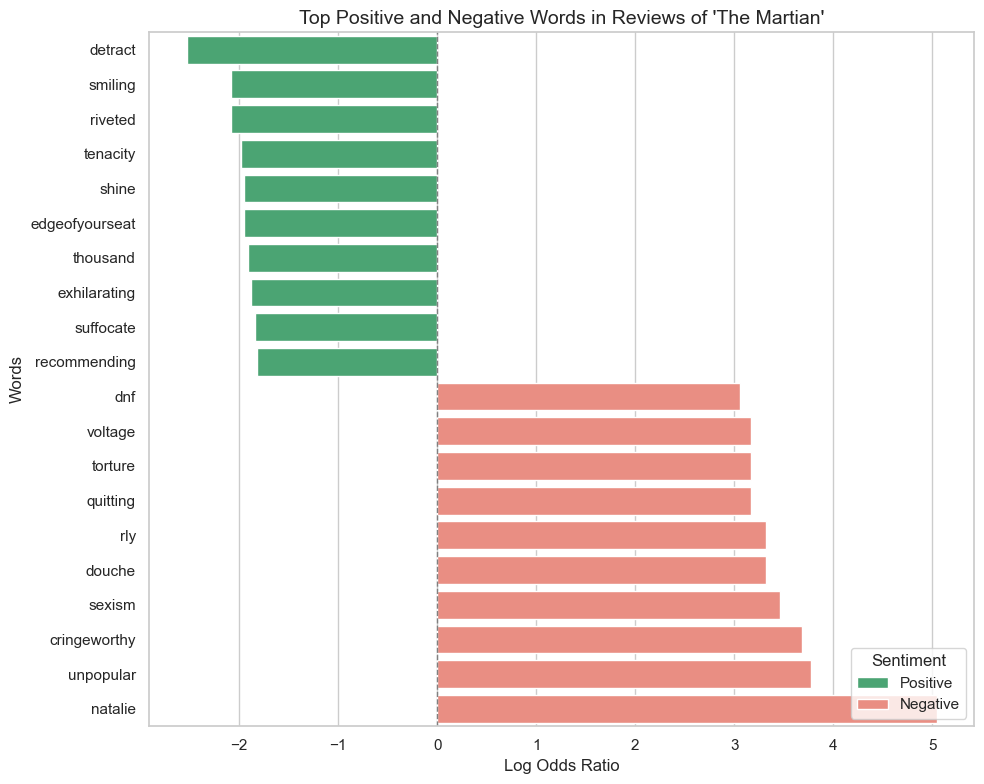

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare and sort the data
all_words = martian_data['top_negative_words'] + martian_data['top_positive_words']
sorted_all = sorted(all_words, key=lambda x: x['log_odds'])

# Create DataFrame for Seaborn
import pandas as pd
df_vis = pd.DataFrame(sorted_all)
df_vis['sentiment'] = df_vis['log_odds'].apply(lambda x: 'Negative' if x > 0 else 'Positive')

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create horizontal barplot
palette = {'Negative': 'salmon', 'Positive': 'mediumseagreen'}
ax = sns.barplot(
    data=df_vis,
    y='word',
    x='log_odds',
    hue='sentiment',
    dodge=False,
    palette=palette
)

# Add styling
plt.title("Top Positive and Negative Words in Reviews of 'The Martian'", fontsize=14)
plt.xlabel("Log Odds Ratio")
plt.ylabel("Words")
plt.axvline(0, color='gray', linestyle='--', lw=1)
plt.legend(title='Sentiment', loc='lower right')
plt.tight_layout()

# Save figure if you want
plt.show()


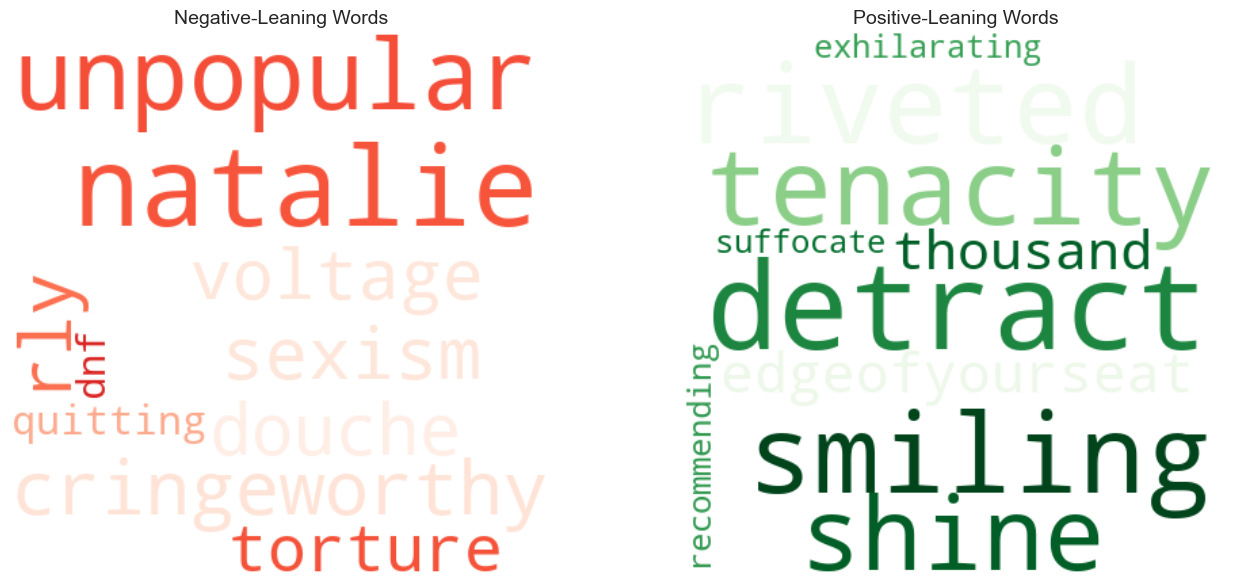

In [116]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get positive and negative word scores separately
positive_words = {w['word']: abs(w['log_odds']) for w in martian_data['top_positive_words']}
negative_words = {w['word']: abs(w['log_odds']) for w in martian_data['top_negative_words']}

# Create word clouds
wc_positive = WordCloud(width=400, height=400, background_color='white', colormap='Greens')
wc_negative = WordCloud(width=400, height=400, background_color='white', colormap='Reds')

wc_positive.generate_from_frequencies(positive_words)
wc_negative.generate_from_frequencies(negative_words)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(wc_negative, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Negative-Leaning Words", fontsize=14)

axes[1].imshow(wc_positive, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Positive-Leaning Words", fontsize=14)

plt.tight_layout()
plt.show()


In [136]:
# Find the result for "The Martian"
ppz_data = next((book for book in results if book['title'] == 'Pride and Prejudice and Zombies'), None)

if ppz_data is None:
    print("Book not found in results.")
else:
    print("Found the book!")

Found the book!


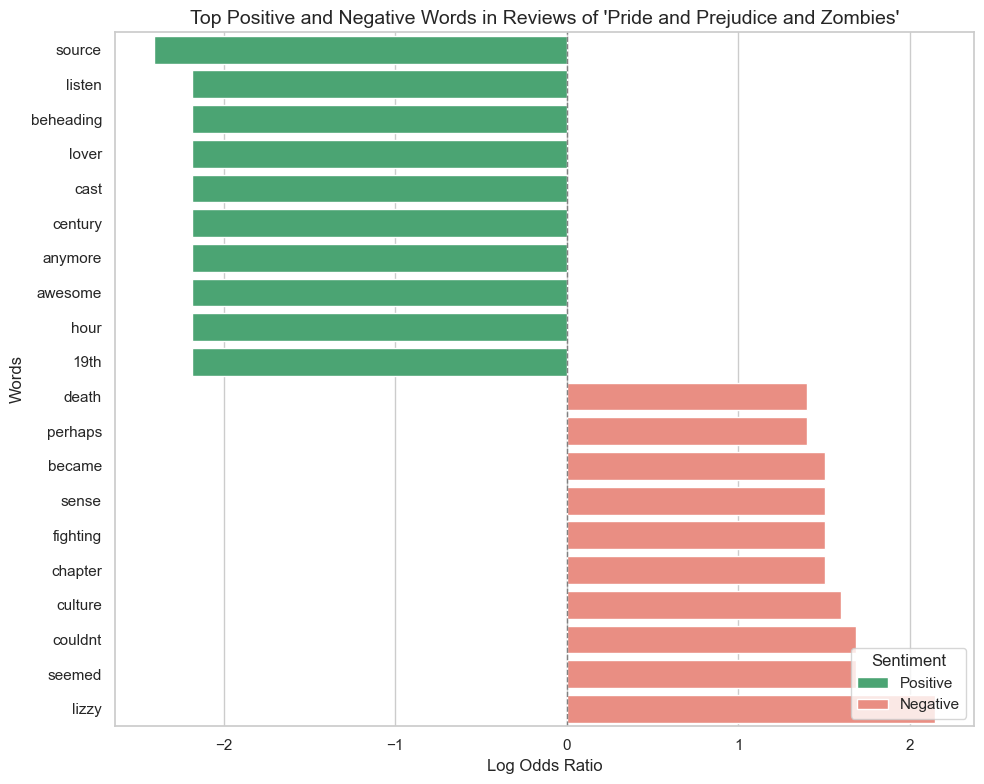

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare and sort the data
all_words = ppz_data['top_negative_words'] + ppz_data['top_positive_words']
sorted_all = sorted(all_words, key=lambda x: x['log_odds'])

# Create DataFrame for Seaborn
import pandas as pd
df_vis = pd.DataFrame(sorted_all)
df_vis['sentiment'] = df_vis['log_odds'].apply(lambda x: 'Negative' if x > 0 else 'Positive')

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create horizontal barplot
palette = {'Negative': 'salmon', 'Positive': 'mediumseagreen'}
ax = sns.barplot(
    data=df_vis,
    y='word',
    x='log_odds',
    hue='sentiment',
    dodge=False,
    palette=palette
)

# Add styling
plt.title("Top Positive and Negative Words in Reviews of 'Pride and Prejudice and Zombies'", fontsize=14)
plt.xlabel("Log Odds Ratio")
plt.ylabel("Words")
plt.axvline(0, color='gray', linestyle='--', lw=1)
plt.legend(title='Sentiment', loc='lower right')
plt.tight_layout()

# Save figure if you want
plt.show()

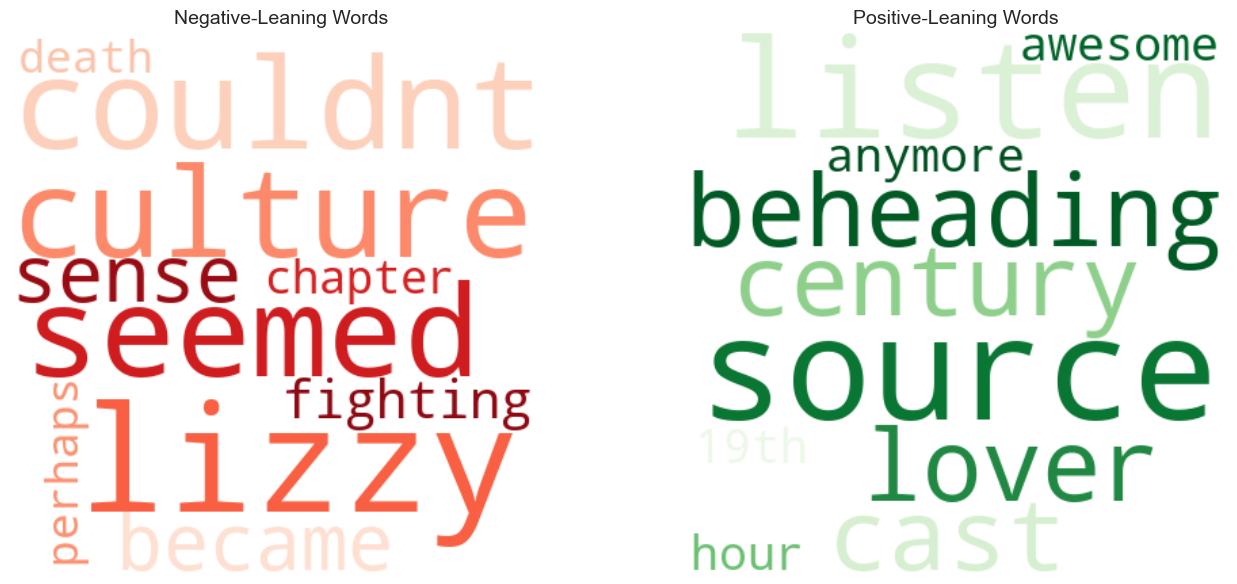

In [138]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get positive and negative word scores separately
positive_words = {w['word']: abs(w['log_odds']) for w in ppz_data['top_positive_words']}
negative_words = {w['word']: abs(w['log_odds']) for w in ppz_data['top_negative_words']}

# Create word clouds
wc_positive = WordCloud(width=400, height=400, background_color='white', colormap='Greens')
wc_negative = WordCloud(width=400, height=400, background_color='white', colormap='Reds')

wc_positive.generate_from_frequencies(positive_words)
wc_negative.generate_from_frequencies(negative_words)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(wc_negative, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Negative-Leaning Words", fontsize=14)

axes[1].imshow(wc_positive, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Positive-Leaning Words", fontsize=14)

plt.tight_layout()
plt.show()